In [298]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [299]:
dataMatch = pd.read_csv("./2020_Problem_D_DATA/matchesNEW.csv")
dataMatch.rename(columns={'Outcome':'GoalDiff'}, inplace=True)
# dataMatch['OpponentID'] = dataMatch['OpponentID'].str.get(8).apply(int)
dataMatch['GoalDiff'] = dataMatch['OwnScore'] - dataMatch['OpponentScore']
dataMatch['Side'] = dataMatch['Side'].apply(lambda x:0 if x == "home" else 1) # home:0, away:1
dataMatch['CoachID'] = dataMatch['CoachID'].str.get(5).apply(int)
dataMatch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 7 columns):
MatchID          38 non-null int64
OpponentID       38 non-null object
GoalDiff         38 non-null int64
OwnScore         38 non-null int64
OpponentScore    38 non-null int64
Side             38 non-null int64
CoachID          38 non-null int64
dtypes: int64(6), object(1)
memory usage: 2.2+ KB


In [300]:
dataColumns = ['Ratings', 'Total Shots', 'Possession%', 'Pass Success%', 'Passes', 'Dribbles', 'Aerials Won', 'Tackles', 'Corners', 'Dispossessed', 'Interceptions', 'Clearances', 'Blocks', 'Offsides', 'Fouls', 'Touches', 'Loss of possession', 'Saves']
# data = pd.DataFrame(index=range(0,38), columns=list(dataMatch.columns)+dataColumns,dtype=float)
for i in dataColumns:
    dataMatch[i] = 0.0
dataColumnsDict = dict(zip(dataColumns, range(len(dataColumns))))
dataColumnsVis  = [0 for i in range(len(dataColumns))]
# data

In [301]:
def extractLine(line):
    words = line.strip().split()
    if (len(words)==1 and words[0] in dataColumns):
        return words[0]
    elif (len(words)==2 and ((words[0]+' '+words[1]) in dataColumns)):
        return (words[0]+' '+words[1])
    elif (len(words)==3 and ((words[0]+' '+words[1]+' '+words[2]) in dataColumns)):
        return (words[0]+' '+words[1]+' '+words[2])
    return ''
def findkeys(file, i):
    f = open(file, encoding='UTF-16')
    line = f.readline()
    while (line):
        key = extractLine(line)
        if (key!='' and dataColumnsVis[dataColumnsDict[key]] == 0):
            dataColumnsVis[dataColumnsDict[key]] = 1
            line = f.readline()
            nums = line.strip().split('-')
            if (key not in dataMatch.columns):
                dataMatch[key] = 0.0
            dataMatch.loc[i,key] = float(nums[dataMatch['Side'][i]])
        key = ''
        line = f.readline()
    f.close()
    return
for i in range(0,38):
    dataColumnsVis  = [0 for i in range(len(dataColumns))]
    file1 = "./match centre/txt"+str(38-i)+".txt"
    file2 = "./chalkboard/txt"  +str(38-i)+".txt"
    findkeys(file1, i)
    findkeys(file2, i)
data = dataMatch

In [302]:
f = open("./board.txt", "r", encoding='UTF-8')
total = f.read().split('\n')
board = []
for i in range(21):
    board.append([])
    board[i] = total[i].strip().split('\t')[:-1]
    board[i].pop(7)
    board[i].pop(6)
    board[i].pop(5)
    board[i].pop(4)
    board[i].pop(3)
    board[i].pop(2)
    board[i].pop(0)
data['Oppo'] = 0
for i in range(1,21):
    if (board[i][0] != '0'):
        for j in range(38):
            if (board[i][0] == data['OpponentID'][j][8:]):
                data['Oppo'][j] = int(board[i][1]) + int(board[i][2])


In [303]:
data = data.sort_index(by=['MatchID'], axis=0, ascending = True)
data.index = range(38)
data = data.drop(['MatchID'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 25 columns):
OpponentID            38 non-null object
GoalDiff              38 non-null int64
OwnScore              38 non-null int64
OpponentScore         38 non-null int64
Side                  38 non-null int64
CoachID               38 non-null int64
Ratings               38 non-null float64
Total Shots           38 non-null float64
Possession%           38 non-null float64
Pass Success%         38 non-null float64
Passes                38 non-null float64
Dribbles              38 non-null float64
Aerials Won           38 non-null float64
Tackles               38 non-null float64
Corners               38 non-null float64
Dispossessed          38 non-null float64
Interceptions         38 non-null float64
Clearances            38 non-null float64
Blocks                38 non-null float64
Offsides              38 non-null float64
Fouls                 38 non-null float64
Touches               38 n

In [304]:
data = data.join(pd.get_dummies(data['Side'], prefix='Side'))
data = data.join(pd.get_dummies(data['CoachID'], prefix='Coach'))

data['Defence'] = data['Tackles'] + data['Dispossessed'] + data['Aerials Won'] + data['Interceptions'] + data['Blocks'] + data['Saves'] + data['Clearances']
data['Attack'] = data['Total Shots'] + data['Dribbles'] + data['Touches'] + data['Corners'] + data['Offsides']

data['Possession%'] = data['Possession%'].apply(lambda x:(x-data['Possession%'].mean())/data['Possession%'].std())
data['Pass Success%'] = data['Pass Success%'].apply(lambda x:(x-data['Pass Success%'].mean())/data['Pass Success%'].std())
data['Passes'] = data['Passes'].apply(lambda x:(x-data['Passes'].min())/(data['Passes'].max()-data['Passes'].min()))
data['Passes'] += data['Possession%'] + data['Pass Success%']

data['Fail'] = -(data['Fouls'] + data['Loss of possession'])

data['Ratings'] = data['Ratings'].apply(lambda x:(x-data['Ratings'].mean())/data['Ratings'].std())
data['Oppo'] = data['Oppo'].apply(lambda x:(x-data['Oppo'].mean())/data['Oppo'].std())
data['Passes'] = data['Passes'].apply(lambda x:(x-data['Passes'].min())/(data['Passes'].max()-data['Passes'].min()))
data['Defence'] = data['Defence'].apply(lambda x:(x-data['Defence'].min())/(data['Defence'].max()-data['Defence'].min()))
data['Attack'] = data['Attack'].apply(lambda x:(x-data['Attack'].min())/(data['Attack'].max()-data['Attack'].min()))
data['Fail'] = data['Fail'].apply(lambda x:-(x-data['Fail'].min())/(data['Fail'].max()-data['Fail'].min()))
def GoalLabel(x):
    if (x<-1):
        return -1
    elif (x>1):
        return 1
    return 0
data['Goal'] = data['GoalDiff'].apply(GoalLabel)

In [305]:
sns.set_style("whitegrid")

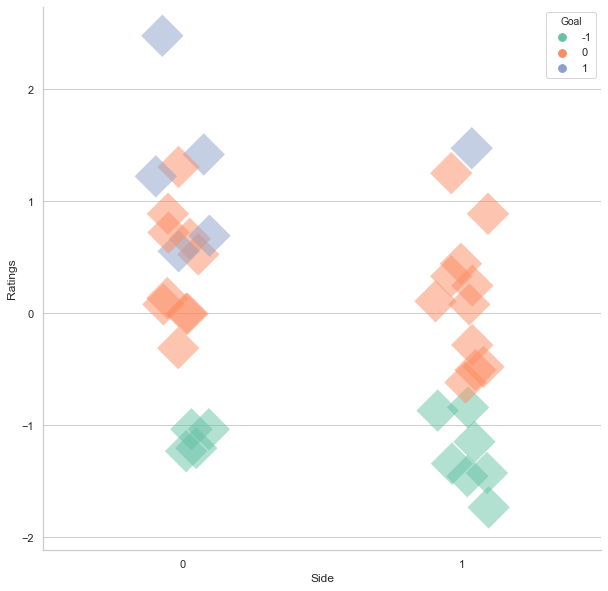

In [306]:
plt.figure(figsize=(10,10))
# fig, axes = plt.subplots(nrows=1,ncols=2) 
# sns.stripplot(x="Side", y="Ratings", data=data, jitter=0.1, ax=axes[0], cmap="Reds")
g = sns.stripplot("Side", "Ratings", "Goal", data=data, palette="Set2", size=30, marker="D", edgecolor="gray", alpha=.5)
sns.despine()
plt.savefig("./CorrAnalysisGraph/Ratings_Side_Goal.png", dpi=300)

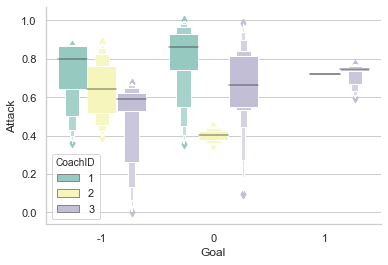

In [307]:
ax = sns.boxenplot(x="Goal", y="Attack", hue="CoachID", data=data, palette="Set3")
sns.despine()
plt.savefig("./CorrAnalysisGraph/Coach_Goal_Attack.png", dpi=300)

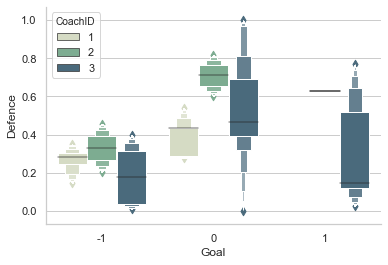

In [308]:
ax = sns.boxenplot(x="Goal", y="Defence", hue="CoachID", data=data, palette=sns.cubehelix_palette(4, start=.5, rot=-.75))
sns.despine()
plt.savefig("./CorrAnalysisGraph/Coach_Goal_Defence.png", dpi=300)

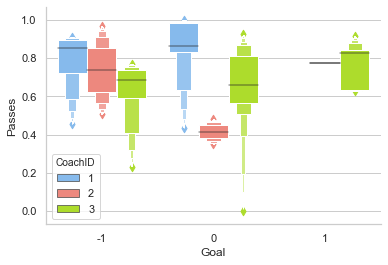

In [309]:
ax = sns.boxenplot(x="Goal", y="Passes", hue="CoachID", data=data, palette=sns.xkcd_palette(['sky blue', 'salmon', 'yellowgreen']))
sns.despine()
plt.savefig("./CorrAnalysisGraph/Coach_Goal_Pass.png", dpi=300)

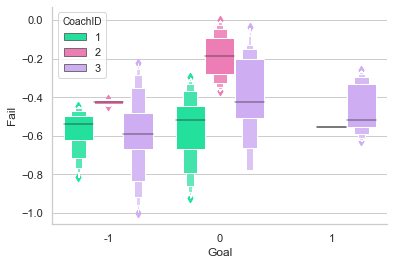

In [310]:
ax = sns.boxenplot(x="Goal", y="Fail", hue="CoachID", data=data, palette=sns.xkcd_palette(['bright sea green', 'bubblegum', 'lilac']))
sns.despine()
plt.savefig("./CorrAnalysisGraph/Coach_Goal_Fail.png", dpi=300)

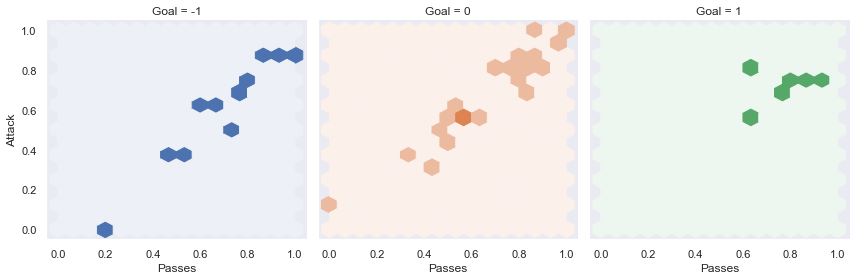

In [311]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=15, cmap=cmap, **kwargs)
with sns.axes_style("dark"):
    g = sns.FacetGrid(data, hue="Goal", col="Goal", height=4)
g.map(hexbin, "Passes", "Attack", extent=[0, 1, 0, 1])
plt.savefig("./CorrAnalysisGraph/Goal_Passes_Attack.png", dpi=300)

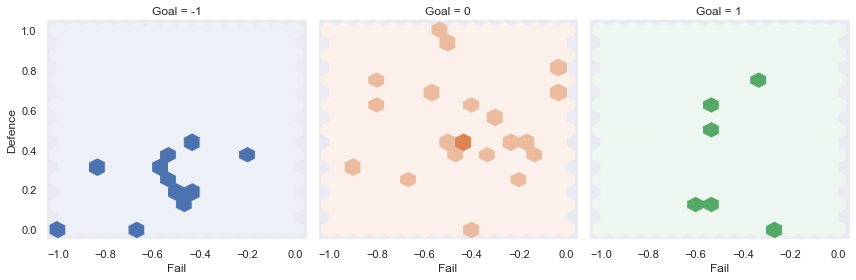

In [312]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=15, cmap=cmap, **kwargs)
with sns.axes_style("dark"):
    g = sns.FacetGrid(data, hue="Goal", col="Goal", height=4)
g.map(hexbin, "Fail", "Defence", extent=[-1, 0, 0, 1])
plt.savefig("./CorrAnalysisGraph/Goal_Fail_Attack.png", dpi=300)

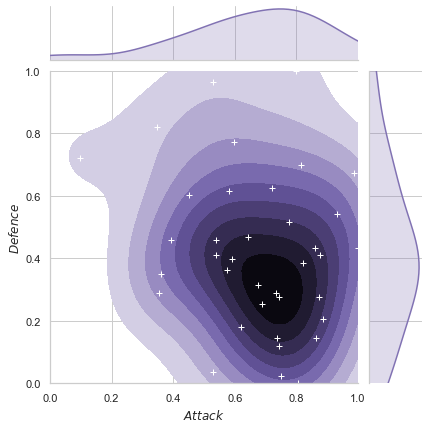

In [313]:
g = sns.jointplot(x="Attack", y="Defence", data=data, kind="kde", color="m")
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
plt.xlim(0,1)
plt.ylim(0,1)
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$Attack$", "$Defence$");
plt.savefig("./CorrAnalysisGraph/Attack_Defence.png", dpi=500)

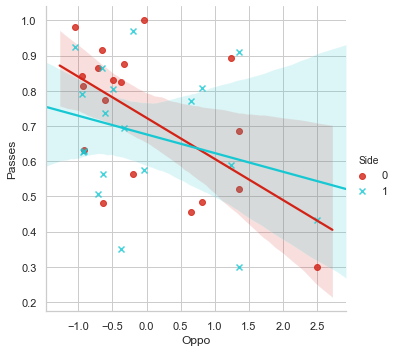

In [315]:
tempdata = data
tempdata['Passes'] = tempdata['Passes'].apply(lambda x:0.3 if x<0.3 else x)
sns.lmplot(x="Oppo", y="Passes", hue="Side", data=data, markers=["o", "x"], palette=sns.hls_palette(2, l=.46, s=.8))
plt.savefig("./CorrAnalysisGraph/Passes_Side_Oppo.png", dpi=300)

In [293]:
data.drop(['Side', 'CoachID', 'OpponentID', 'OwnScore', 'OpponentScore', 'Tackles', 'Dispossessed', 'Aerials Won', 'Interceptions', 'Blocks', 'Saves', 'Clearances', 'Total Shots', 'Dribbles', 'Touches', 'Corners', 'Offsides', 'Possession%', 'Pass Success%', 'Fouls', 'Loss of possession', 'GoalDiff'], axis=1, inplace=True)
data

,Ratings,Passes,Oppo,Side_0,Side_1,Coach_1,Coach_2,Coach_3,Defence,Attack,Fail,Goal
0,0.888853,0.982458,-1.051304,1,0,1,0,0,0.542169,0.931818,-0.296296,0
1,-0.477823,0.433890,2.502856,0,1,1,0,0,0.289157,0.353535,-0.925926,0
2,-0.840410,0.809066,0.815126,0,1,1,0,0,0.289157,0.734848,-0.814815,-1
3,-1.230888,0.893098,1.232095,1,0,1,0,0,0.144578,0.863636,-0.444444,-1
4,-1.732932,0.909810,1.351229,0,1,1,0,0,0.277108,0.873737,-0.518519,-1
5,0.526265,0.830957,-0.495346,1,0,1,0,0,0.277108,0.742424,-0.666667,0
6,-0.310475,1.000000,-0.038666,1,0,1,0,0,0.433735,1.000000,-0.518519,0
7,0.442591,0.864766,-0.654191,0,1,1,0,0,0.433735,0.861111,-0.444444,0
8,-1.035649,0.455028,0.656281,1,0,1,0,0,0.349398,0.361111,-0.555556,-1
9,-0.868301,0.969074,-0.197511,0,1,0,1,0,0.204819,0.886364,-0.444444,-1


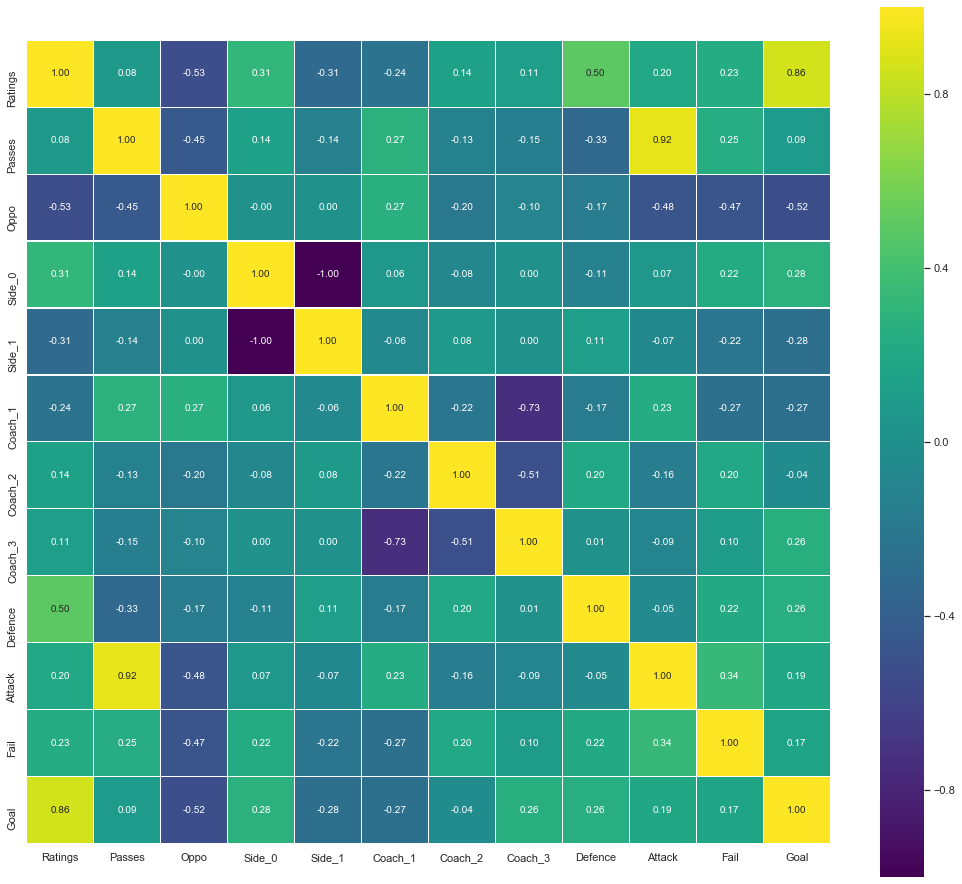

In [294]:
# 特征间相关性分析
Correlation = pd.DataFrame(data[data.columns.to_list()])
colormap = plt.cm.viridis
plt.figure(figsize=(18,16))
sns.heatmap(Correlation.astype(float).corr(), linewidths=0.1, vmax=1.0, cmap=colormap, linecolor='white', annot=True, square=True, fmt=".2f")
plt.savefig("./CorrAnalysisGraph/Corr.png", dpi=1000)

0.6
0.6581196581196581


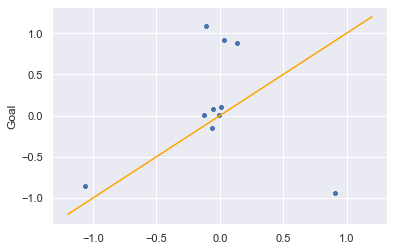

In [295]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
xtrain, xtest, ytrain, ytest = train_test_split(data.drop(['Goal', 'Ratings'], axis=1,  inplace=False), data['Goal'])
model = RandomForestClassifier(n_estimators=50, random_state=0, max_depth=3, max_features="sqrt")
model.fit(xtrain, ytrain)
ypred = model.predict(xtest)
print (accuracy_score(ytest, ypred))
print (cross_val_score(model, data.drop(['Goal', 'Ratings'], axis=1,  inplace=False), data['Goal'], scoring='accuracy').mean())
sns.set(color_codes=True)
randxy1 = [np.random.random_sample()*0.3-0.15 for i in range(len(ytest))]
randxy2 = [np.random.random_sample()*0.3-0.15 for i in range(len(ytest))]
sns.scatterplot(x=ypred+randxy1, y=ytest+randxy2)
sns.lineplot(x=np.linspace(-1.2,1.2), y=np.linspace(-1.2,1.2), color='orange')